# CNN for acoustic scene classfication: my life environment

Date: March 1, 2019

Neural network: input MFSCs to CNN

## Preparing data set for CNN

In [46]:
DATASET_FOLDER = '../dataset/data_environment'

%run ../oscilloscope/script/dataset.py

ds = DataSet(DATASET_FOLDER)
train_data, train_labels, test_data, test_labels = ds.generate(flatten=False)
shape = ds.shape
class_labels = ds.class_labels

((490, 96, 40, 1), (210, 96, 40, 1))

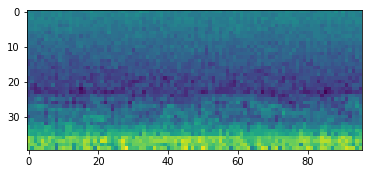

In [47]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.imshow(np.rot90(train_data[0].reshape(ds.shape)))
train_data.shape, test_data.shape

### CNN model

In [54]:
from keras import layers
from keras import models

model = models.Sequential()

model.add(layers.Conv2D(4, (3, 3), activation='relu', input_shape=(*shape, 1)))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(8, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))

model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(len(class_labels), activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 94, 38, 4)         40        
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 47, 19, 4)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 45, 17, 8)         296       
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 22, 8, 8)          0         
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 20, 6, 16)         1168      
_________________________________________________________________
max_pooling2d_27 (MaxPooling (None, 10, 3, 16)         0         
_________________________________________________________________
flatten_9 (Flatten)          (None, 480)               0         
__________

In [55]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

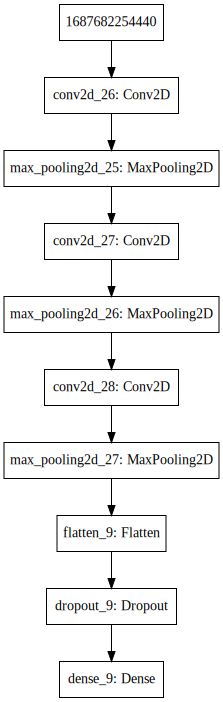

In [56]:
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

## Training CNN

In [57]:
EPOCHS = 50
history = model.fit(train_data, train_labels, epochs=EPOCHS, validation_data=(test_data, test_labels))

Train on 490 samples, validate on 210 samples
Epoch 1/50
490/490 [==============================] - 25s 51ms/step - loss: 1.9522 - acc: 0.2224 - val_loss: 1.7570 - val_acc: 0.4095
Epoch 2/50
490/490 [==============================] - 23s 46ms/step - loss: 1.6164 - acc: 0.4061 - val_loss: 1.3392 - val_acc: 0.6048
Epoch 3/50
490/490 [==============================] - 21s 43ms/step - loss: 1.2512 - acc: 0.5286 - val_loss: 1.0500 - val_acc: 0.6143
Epoch 4/50
490/490 [==============================] - 21s 43ms/step - loss: 1.0138 - acc: 0.6469 - val_loss: 0.8345 - val_acc: 0.6667
Epoch 5/50
490/490 [==============================] - 25s 50ms/step - loss: 0.8441 - acc: 0.6776 - val_loss: 0.7335 - val_acc: 0.7048
Epoch 6/50
490/490 [==============================] - 20s 42ms/step - loss: 0.8108 - acc: 0.6878 - val_loss: 0.6112 - val_acc: 0.7667
Epoch 7/50
490/490 [==============================] - 22s 45ms/step - loss: 0.7193 - acc: 0.7204 - val_loss: 0.5777 - val_acc: 0.7857
Epoch 8/50
490/4

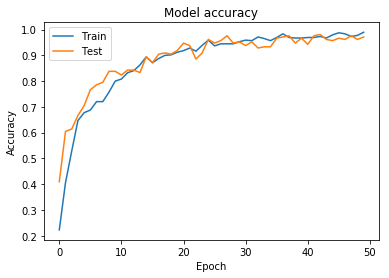

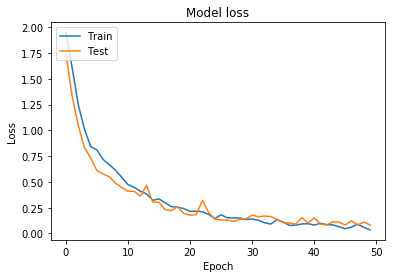

In [58]:
%run history.py
%matplotlib inline

plot_accuracy(history)
plot_loss(history)

## Save the model

In [59]:
import datetime

dt = datetime.datetime.today().strftime('%Y%m%d%H%M%S')
filename = DATASET_FOLDER + '/cnn_for_aed_{}.h5'.format(dt)
model.save(filename)

## Load the model

In [60]:
del model
model = models.load_model(filename)

## Confirmation

In [61]:
import numpy as np
import matplotlib.pyplot as plt

In [62]:
layer_outputs = [layer.output for layer in model.layers]
#layer_outputs

In [63]:
activation_model = models.Model(inputs=model.input, outputs=layer_outputs)
activations = activation_model.predict(test_data)
#activations[0][0,:,:,0].shape

In [64]:
class_labels

['train', 'station', 'cafe', 'mall', 'port', 'street', 'office']

In [65]:
(activations[-1][:10]*100).astype(int)

array([[ 0, 99,  0,  0,  0,  0,  0],
       [ 0,  0,  0, 99,  0,  0,  0],
       [ 0, 99,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 99,  0,  0],
       [99,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0, 99,  0,  0],
       [ 0,  0,  0,  0,  0, 99,  0],
       [ 0, 99,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 99],
       [ 0,  0,  0, 99,  0,  0,  0]])

In [66]:
test_labels[:10].astype(int)

array([[0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0],
       [0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1],
       [0, 0, 0, 1, 0, 0, 0]])